<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 172 (delta 26), reused 39 (delta 10), pack-reused 106
Receiving objects: 100% (172/172), 16.81 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle
import random

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
seed = 456
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
#Set these important parameters
#Dimension of the latent space 
d = 2
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 600
#Number of layers
num_layers = 2
#Number of neurons
num_neur=500 


In [ ]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [ ]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [ ]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

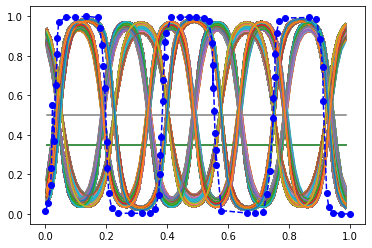

In [ ]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [ ]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [ ]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 72) (4753, 3) (594, 2, 72) (594, 3) (595, 2, 72) (595, 3)


In [ ]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [ ]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  # torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [ ]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/600 	 train loss 0.06706281751394272 	 val loss 0.0024937482085078955
EPOCH 2/600 	 train loss 0.00041207208414562047 	 val loss 0.0004170910979155451
EPOCH 3/600 	 train loss 0.00021014556114096195 	 val loss 0.00027919470448978245
EPOCH 4/600 	 train loss 0.0001694638776825741 	 val loss 0.00018297410861123353
EPOCH 5/600 	 train loss 0.00013414704881142825 	 val loss 0.00014243020268622786
EPOCH 6/600 	 train loss 0.0001288419298361987 	 val loss 0.00014034770720172673
EPOCH 7/600 	 train loss 0.00012437494297046214 	 val loss 0.00022865082428324968
EPOCH 8/600 	 train loss 0.0001225262094521895 	 val loss 0.00013076839968562126
EPOCH 9/600 	 train loss 0.00010375664714956656 	 val loss 0.0003293002664577216
EPOCH 10/600 	 train loss 0.00013223540736362338 	 val loss 0.0002365859254496172
EPOCH 11/600 	 train loss 0.0001096479463740252 	 val loss 0.00013798661530017853
EPOCH 12/600 	 train loss 0.00010588322038529441 	 val loss 0.00013162840332370251
EPOCH 13/600 	 train los

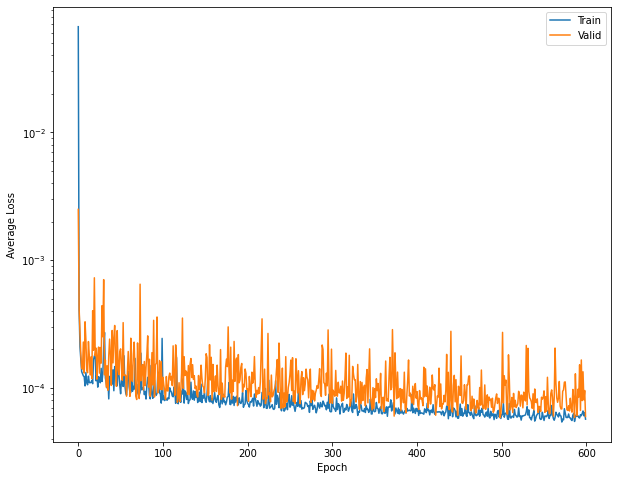

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 0.00013060678611509502
For image 1, the loss = 3.306337748654187e-05
For image 2, the loss = 1.9533563317963853e-05
For image 3, the loss = 7.091900624800473e-05
For image 4, the loss = 7.636000373167917e-05
For image 5, the loss = 1.1344080121489242e-05
For image 6, the loss = 3.107382872258313e-05
For image 7, the loss = 0.00011186176561750472
For image 8, the loss = 5.6516520999139175e-05
For image 9, the loss = 3.857955744024366e-05


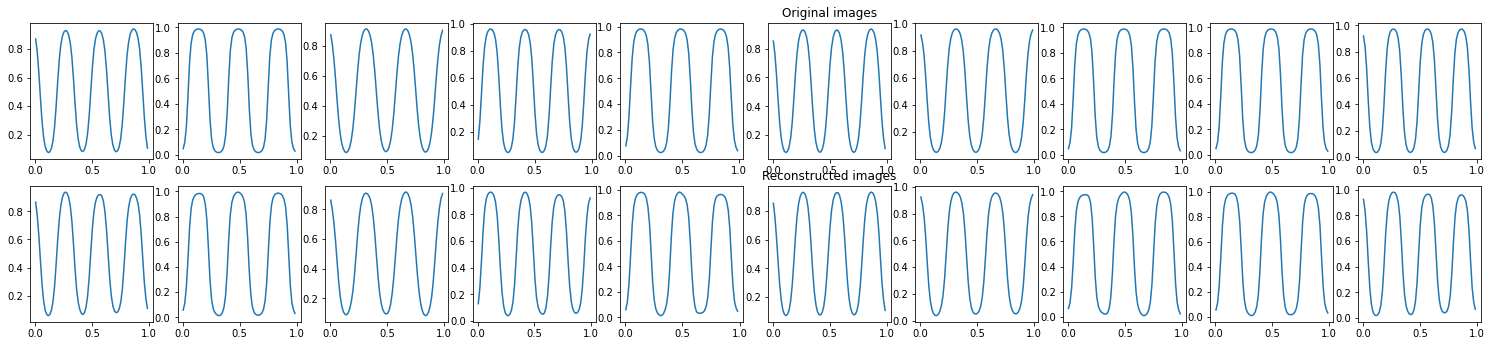

In [ ]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([2.4913, 0.1470])
tensor([2.2215, 2.4579])


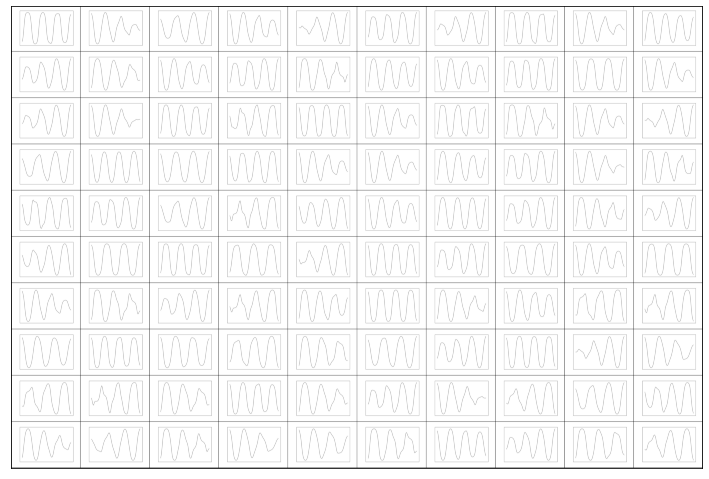

In [ ]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [ ]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  # print(label_index)

In [ ]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,label0,label1,label2
0,-0.116583,-0.045720,0.127,0.226,0.5461
1,-0.046357,-0.059386,0.105,0.499,0.4736
2,7.288292,0.438536,0.121,-0.0452,-0.4587
3,0.506144,-0.073807,0.0645,0.527,0.1107
4,7.298763,0.263710,0.149,-0.446,-0.34307
...,...,...,...,...,...
4748,3.384851,-3.325107,0.171,-0.138,0.4891
4749,0.312703,0.005099,0.0861,0.0777,0.37946
4750,-0.124654,-0.065983,0.129,0.578,0.45588
4751,7.221900,0.308234,0.102,-0.0549,-0.08765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.


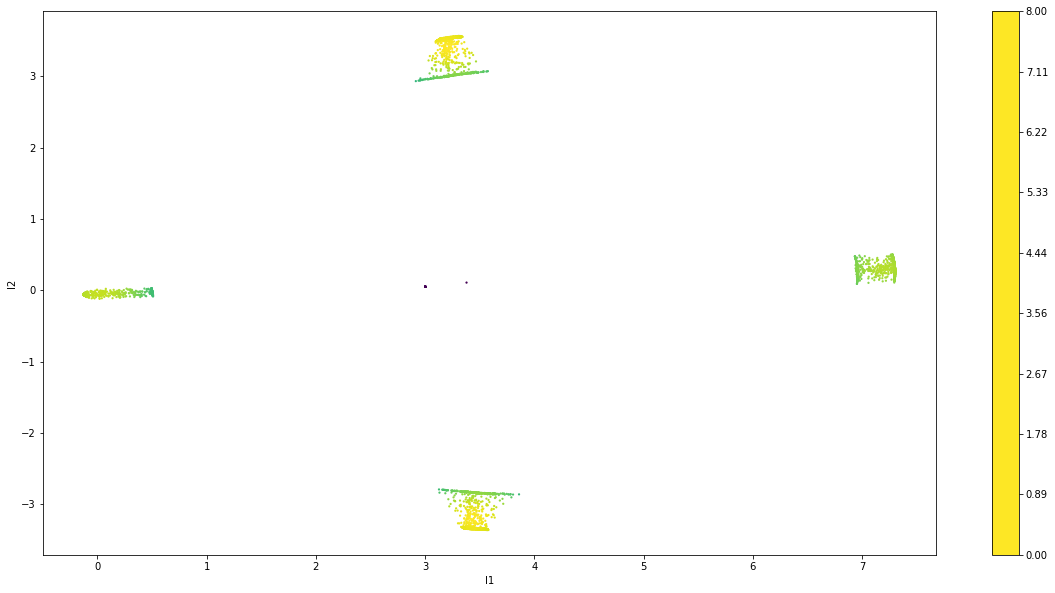

In [ ]:
#Plotting the joint distributions for the latent variables

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l2')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,2)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l3')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,3)
# x = df_encoded_samples['l2']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l3')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=df_encoded_samples.label0.astype(str),
                 labels={'0': 'l1', '1': 'l2'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=df_encoded_samples.label1.astype(str),
                 labels={'0': 'l1', '1': 'l2'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=df_encoded_samples.label2.astype(str),
                 labels={'0': 'l1', '1': 'l2'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 144]) torch.Size([4753, 144]) torch.Size([4753, 2]) torch.Size([4753, 3])
torch.Size([594, 144]) torch.Size([594, 144]) torch.Size([594, 2]) torch.Size([594, 3])
torch.Size([595, 144]) torch.Size([595, 144]) torch.Size([595, 2]) torch.Size([595, 3])


In [ ]:
num_epochs = 2000
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [ ]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [ ]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/2000 	 train loss 0.06124579906463623 	 val loss 0.026331910863518715
EPOCH 2/2000 	 train loss 0.022468365728855133 	 val loss 0.02881302684545517
EPOCH 3/2000 	 train loss 0.02240614779293537 	 val loss 0.025179553776979446
EPOCH 4/2000 	 train loss 0.02188778668642044 	 val loss 0.021871423348784447
EPOCH 5/2000 	 train loss 0.021146384999155998 	 val loss 0.020788021385669708
EPOCH 6/2000 	 train loss 0.020407533273100853 	 val loss 0.022301146760582924
EPOCH 7/2000 	 train loss 0.019748976454138756 	 val loss 0.02640816941857338
EPOCH 8/2000 	 train loss 0.01946459896862507 	 val loss 0.024660641327500343
EPOCH 9/2000 	 train loss 0.019365066662430763 	 val loss 0.0235940832644701
EPOCH 10/2000 	 train loss 0.019630543887615204 	 val loss 0.020752951502799988
EPOCH 11/2000 	 train loss 0.0190002229064703 	 val loss 0.021215276792645454
EPOCH 12/2000 	 train loss 0.01855355128645897 	 val loss 0.02869202196598053
EPOCH 13/2000 	 train loss 0.01899079419672489 	 val loss 0.0

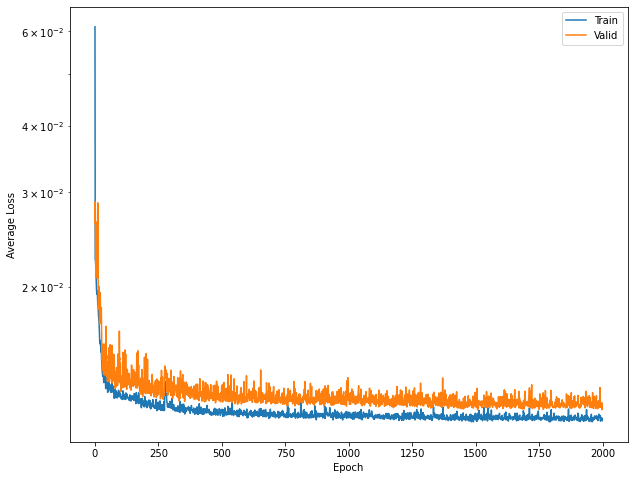

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.062297,-0.074350,0.481765,0.071,-0.069,0.53973
1,0.156023,-0.204501,-0.424846,0.192,-0.209,-0.42088
2,0.126419,0.365763,0.243391,0.108,0.44,0.35034
3,0.156674,-0.421702,-0.184186,0.14,-0.416,-0.17592
4,0.156054,-0.245364,-0.297918,0.186,-0.159,-0.21434
...,...,...,...,...,...,...
590,0.070376,-0.433848,-0.182851,0.0796,-0.389,-0.05212
591,0.143477,0.124874,0.482442,0.138,0.0306,0.35067
592,0.068699,-0.220255,-0.353696,0.0603,-0.385,-0.46875
593,0.152891,-0.320084,0.436307,0.162,-0.405,0.5309


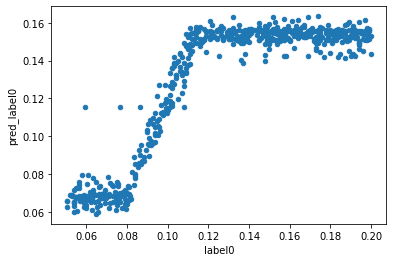

In [ ]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

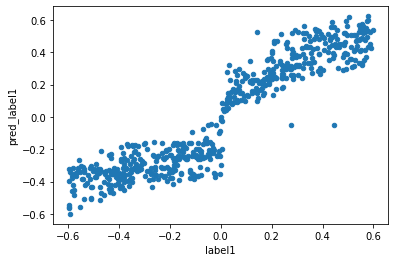

In [ ]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

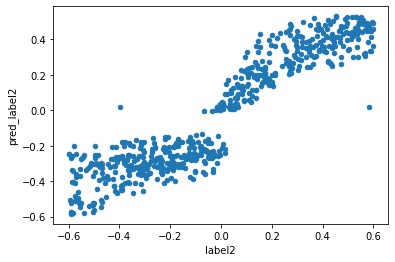

In [ ]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

,l1,l2,label0,label1,label2
0,6.102227,1.405969,0.118739,-0.173801,-0.641154


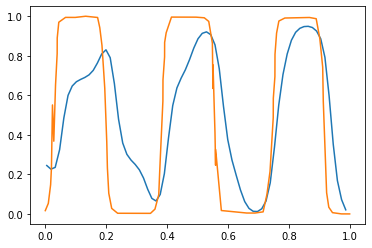

In [ ]:
expt_arr_n = expt_arr[np.newaxis,:,:]
# expt_arr_n.shape

expt_labels = []

img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)
model.eval().to(device)

with torch.no_grad():
  encoded_img  = encoder(img)
  expt_decoded_img = decoder(encoded_img)
  out_label  = model(encoder(img))

  encoded_img = encoded_img.flatten().cpu().numpy()
  out_label = out_label.cpu().numpy()

  # print(encoded_img)
  # print(out_label)
  expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}

# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(encoder(img)).cpu().numpy()

for i in range(nlabel):
    label_index = 'label'+str(i)
    expt_label[label_index] = out_label[i]

plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])

expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



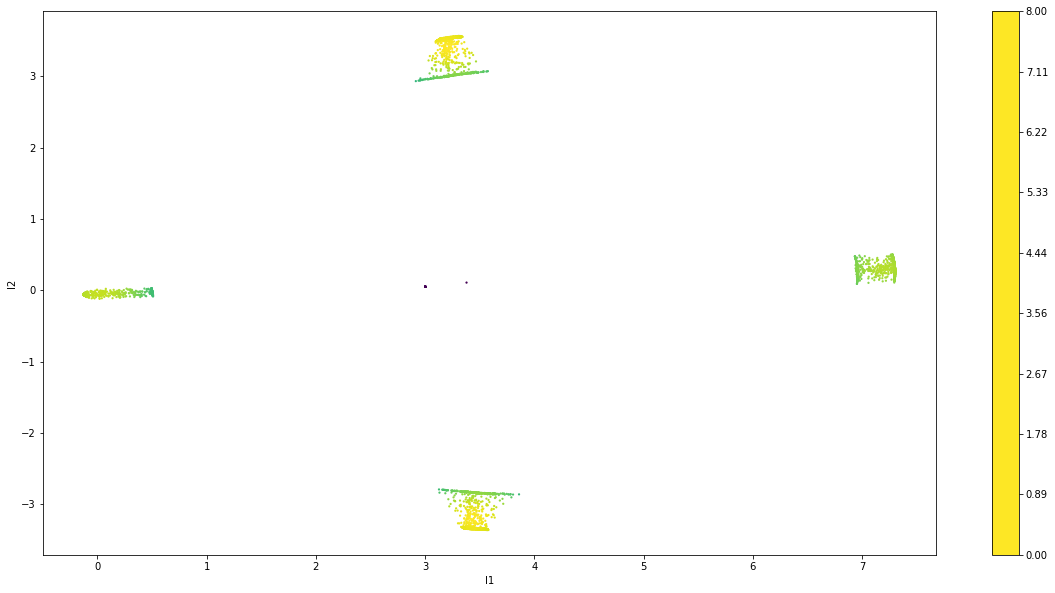

In [ ]:
#Plotting the joint distributions for the latent variables for the simulated sld files
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l1')
ax.set_ylabel('l2')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,2)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l1')
# ax.set_ylabel('l3')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,3)
# x = df_encoded_samples['l2']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l2')
# ax.set_ylabel('l3')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

,l1,l2,label0,label1,label2
0,5.602227,0.905969,0.045939,-0.141912,-0.454240
1,5.612328,0.916070,0.046540,-0.142600,-0.457687
2,5.622429,0.926171,0.047142,-0.143287,-0.461133
3,5.632530,0.936272,0.047743,-0.143975,-0.464579
4,5.642631,0.946373,0.048344,-0.144662,-0.468025
...,...,...,...,...,...
95,6.561823,1.865565,0.219017,-0.201449,-0.825621
96,6.571924,1.875666,0.221221,-0.202057,-0.829675
97,6.582025,1.885767,0.223425,-0.202665,-0.833729
98,6.592126,1.895868,0.225629,-0.203272,-0.837783


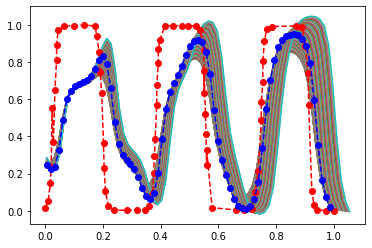

In [ ]:
#Varying l1, l2 and l3 around the values above
x1 = expt_labels[0]['l1']
x2 = expt_labels[0]['l2']
# x3 = expt_labels[0]['l3']
lv1_vals = np.linspace(x1-.5,x1+.5,100)
lv2_vals = np.linspace(x2-.5,x2+.5,100)
# lv3_vals = np.linspace(x3-.5,x3+.5,100)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None], lv3_vals[:, None]), axis=-1)
lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
lv_vals = torch.from_numpy(lv_vals).float().to(device)

#Determining the labels and the decoded images for those l1,l2,l3 above
model.eval().to(device)
with torch.no_grad():
  out_label  = model(lv_vals).cpu().numpy()
# out_label.shape

encoder.eval().to(device)
decoder.eval().to(device)

with torch.no_grad():
  decoded_img = decoder(lv_vals)

for x in range(decoded_img.shape[0]):
  plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1],'ro',linestyle='dashed')
plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1],'bo',linestyle='dashed') 

deg_model = pd.DataFrame({'l1':lv_vals.cpu().numpy()[:,0],'l2':lv_vals.cpu().numpy()[:,1],
                       'label0': out_label[:,0],'label1':out_label[:,1],'label2':out_label[:,2]})
deg_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
PATH = '/content/gdrive/MyDrive/'
torch.save(encoder.state_dict(), PATH + 'l2encoder.pt' )
torch.save(decoder.state_dict(), PATH + 'l2decoder.pt' )
torch.save(model.state_dict(), PATH + 'l2mlp.pt' )

In [ ]:
#Reloading the encoder and decoder
encoder.load_state_dict(torch.load(PATH + 'l2encoder.pt'))
decoder.load_state_dict(torch.load(PATH + 'l2decoder.pt'))
model.load_state_dict(torch.load(PATH + 'l2mlp.pt'))

<All keys matched successfully>